In [1]:
import os
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
sys.path.append('../src')
sys.path.append('../../src')
from Library import VerboseLibrary
import matplotlib.colors as mcolors

named_colors = list(mcolors.TABLEAU_COLORS)

device = 'cpu'#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load Models

In [2]:
model_names = sorted(os.listdir('./models_R'))
len(model_names)

10

In [3]:
model_coefficient_history = {}
model_coefficient_mask = {}
model_coefficients = {}

for name in tqdm(model_names):
    model = torch.load(os.path.join('.', 'models_R', name)).to(device)
    model_coefficient_history[name] = np.array(model.coefficient_history)
    model_coefficients[name] = np.array(model.coefficient_mask.detach().cpu().numpy() * model.coefficients.detach().cpu().numpy())
    model_coefficient_mask[name] = np.array(model.coefficient_mask)

100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


In [4]:
# weak criterion
model_sin_detected = {name: model_coefficient_mask[name][10, 0] for name in model_names}
model_any_detected = {name: model_coefficient_mask[name].any() and not model_coefficient_mask[name][10, 0] for name in model_names}
model_none_detected = {name: not model_coefficient_mask[name].any() for name in model_names}

# Coefficients

In [5]:
masked_coefficient_list = np.array([model_coefficients[name].round(2) for name in model_names], dtype=object)

In [6]:
masked_coefficient_list[masked_coefficient_list == 0] = '-'

In [7]:
pd.DataFrame(masked_coefficient_list[:, :, 0], columns=['*'.join(l) for l in VerboseLibrary(model.library).build_verbose()])

1   z_1 dz_1/dt z_1*z_1 z_1*dz_1/dt dz_1/dt*dz_1/dt z_1*z_1*z_1  \
0     - -0.32       -       -           -               -           -   
1     -     -       -    0.27           -           -0.72           -   
2     - -0.31       -       -           -               -           -   
3     -     -       -       -           -               -           -   
4     -     -       -       -           -               -           -   
5     - -0.13       -       -           -               -           -   
6     -     -       -       -           -               -           -   
7  0.23     -       -   -0.35           -               -           -   
8  0.13 -0.52       -       -           -               -           -   
9     -     -       -       -           -               -           -   

  z_1*z_1*dz_1/dt z_1*dz_1/dt*dz_1/dt dz_1/dt*dz_1/dt*dz_1/dt sin(z_1)  \
0               -                   -                       -    -0.87   
1               -               -1.12                       -        -   
2               -                   -                       -    -0.85   
3               -                   -                       -        -   
4               -                   -                       -        -   
5               -                   -                       -    -0.88   
6               -                   -                       -        -   
7               -                   -                       -        -   
8               -                   -                       -        -   
9               -                   -                       -        -   

  sin(dz_1/dt)  
0            -  
1            -  
2            -  
3            -  
4            -  
5            -  
6            -  
7            -  
8            -  
9            -

# Only Sin Curves

In [8]:
model_sin_history = {name: model_coefficient_history[name][:, 10, 0] for name in model_names}
model_other_history = {name: model_coefficient_history[name][:, [i for i in range(12) if i != 10], 0] for name in model_names}

100%|██████████| 10/10 [00:00<00:00, 251.42it/s]


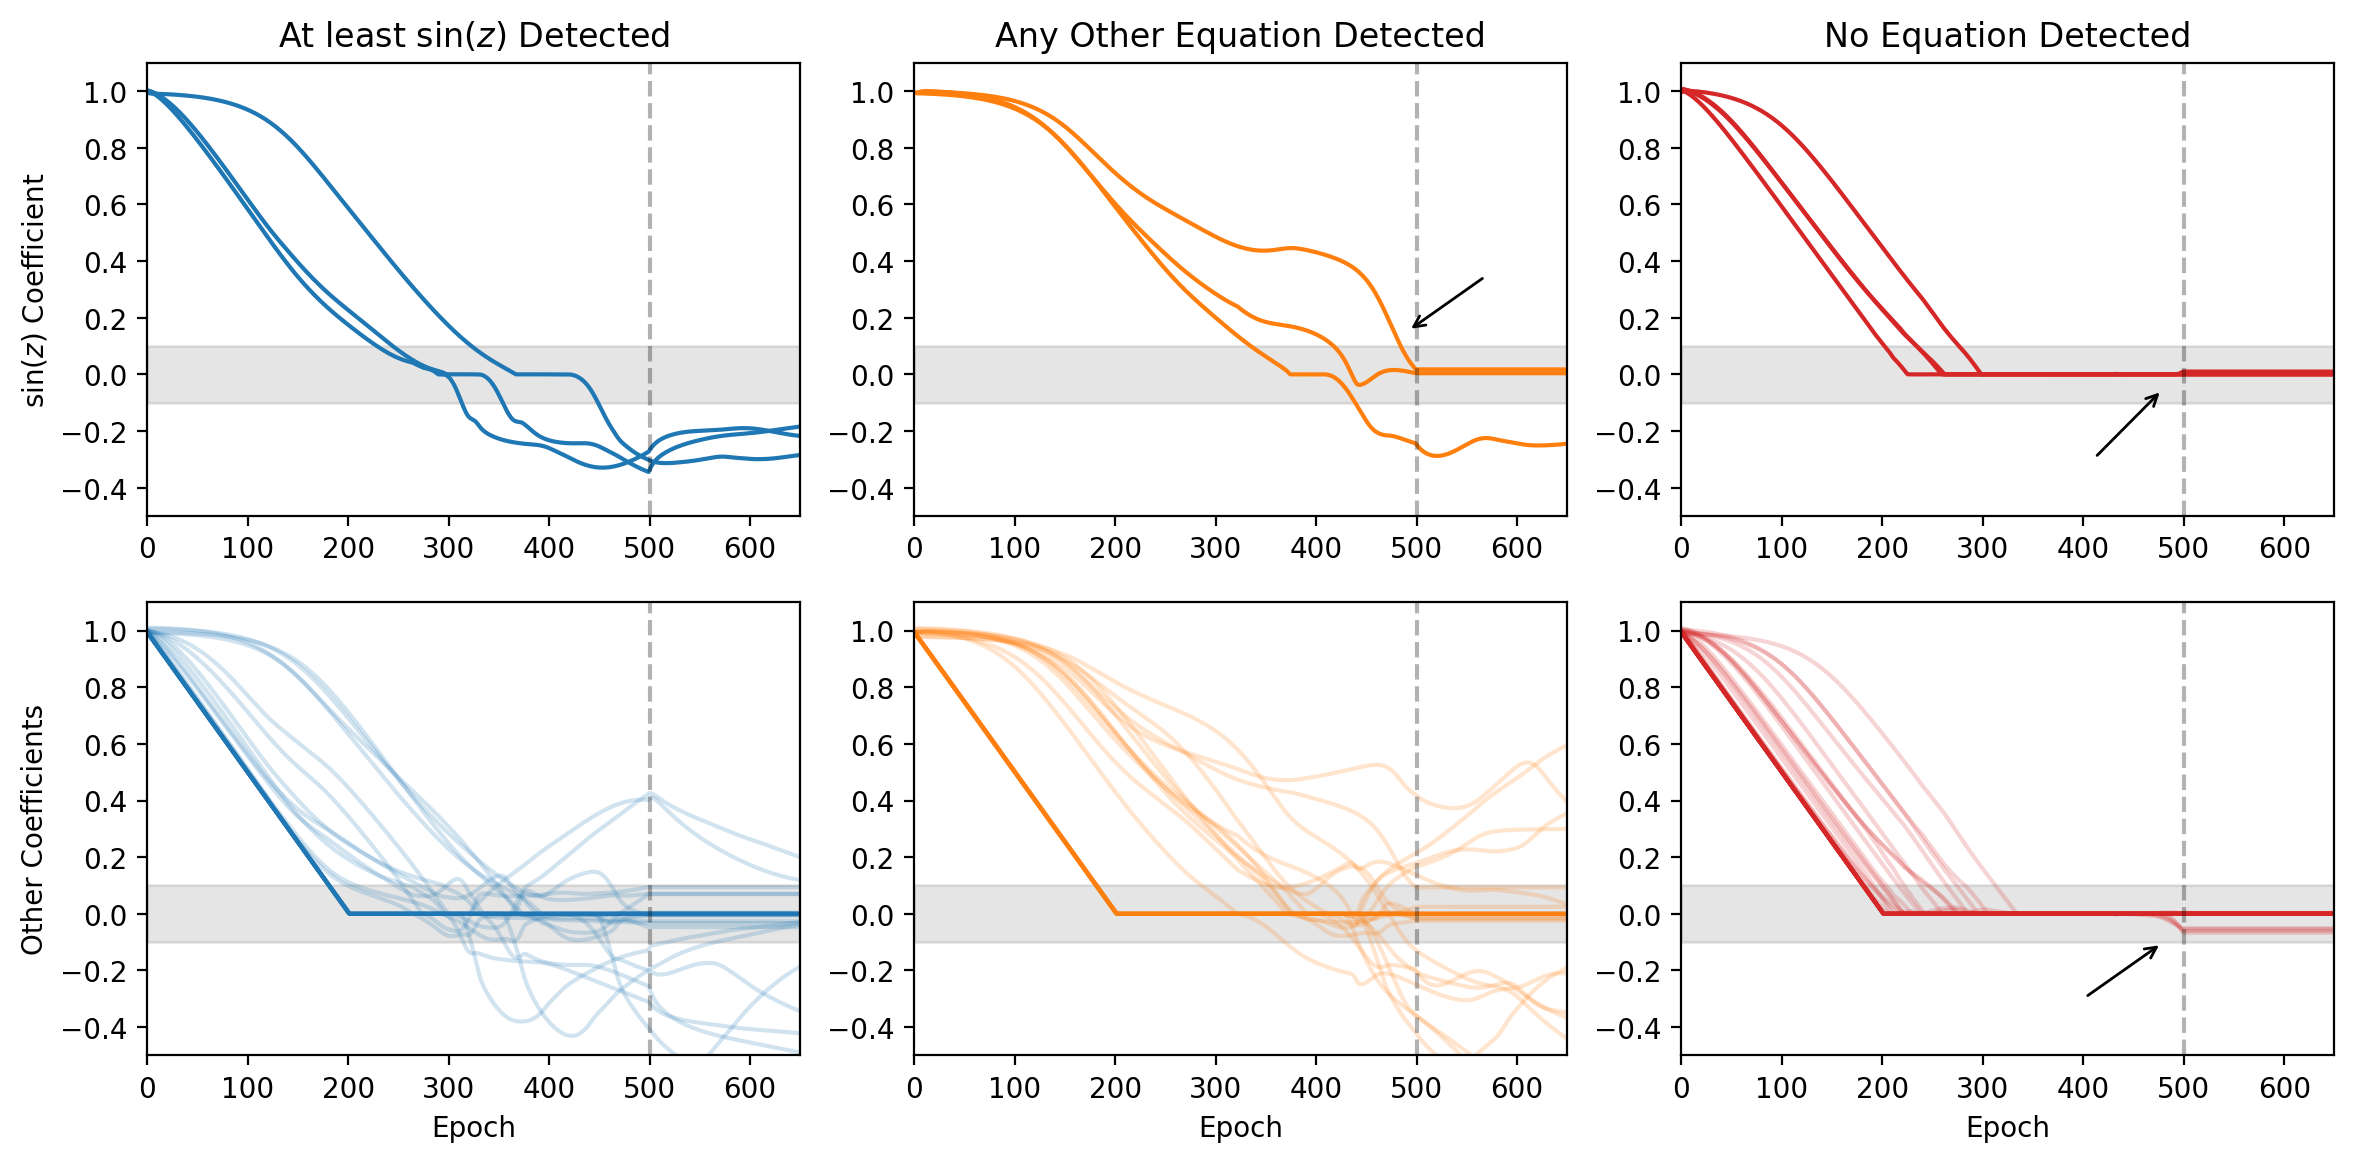

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(21/1.8, 10/1.8), dpi=200)
fig.tight_layout(w_pad=1, h_pad=1)
xlim = 650

for name in tqdm(model_names):
    if model_sin_detected[name]:
        axes[0][0].plot(model_sin_history[name][:xlim], color='tab:blue');
        axes[1][0].plot(model_other_history[name][:xlim], color='tab:blue', alpha=0.2);
    if model_any_detected[name]:
        axes[0][1].plot(model_sin_history[name][:xlim], color='tab:orange');
        axes[1][1].plot(model_other_history[name][:xlim], color='tab:orange', alpha=0.2);
    if model_none_detected[name]:
        axes[0][2].plot(model_sin_history[name][:xlim], color='tab:red');
        axes[1][2].plot(model_other_history[name][:xlim], color='tab:red', alpha=0.2);

axes[0][0].set_title(r'At least $\sin(z)$ Detected');
axes[0][1].set_title(f'Any Other Equation Detected');
axes[0][2].set_title(f'No Equation Detected');

axes[0][0].set_ylabel(r'$\sin(z)$ Coefficient');
axes[1][0].set_ylabel('Other Coefficients');

# Draw an arrow in interesting positions.
axes[0][2].annotate('', xy=(480, -0.05), xytext=(410, -0.3), arrowprops={'arrowstyle': '->'})
axes[1][2].annotate('', xy=(480, -0.1), xytext=(400, -0.3), arrowprops={'arrowstyle': '->'})
axes[0][1].annotate('', xy=(490, 0.15), xytext=(570, 0.35), arrowprops={'arrowstyle': '->'})

for ax in axes[0]:
    ax.set_xlim(0, xlim); ax.axhspan(-0.1, 0.1, color='black', alpha=0.1);
    for threshold_epoch in np.arange(500, xlim, 500): ax.axvline(threshold_epoch, color='black', alpha=0.3, linestyle='--'); ax.set_ylim(-0.5, 1.1)

for ax in axes[1]:
    ax.set_xlabel('Epoch');  ax.set_xlim(0, xlim); ax.axhspan(-0.1, 0.1, color='black', alpha=0.1);
    for threshold_epoch in np.arange(500, xlim, 500): ax.axvline(threshold_epoch, color='black', alpha=0.3, linestyle='--'); ax.set_ylim(-0.5, 1.1)

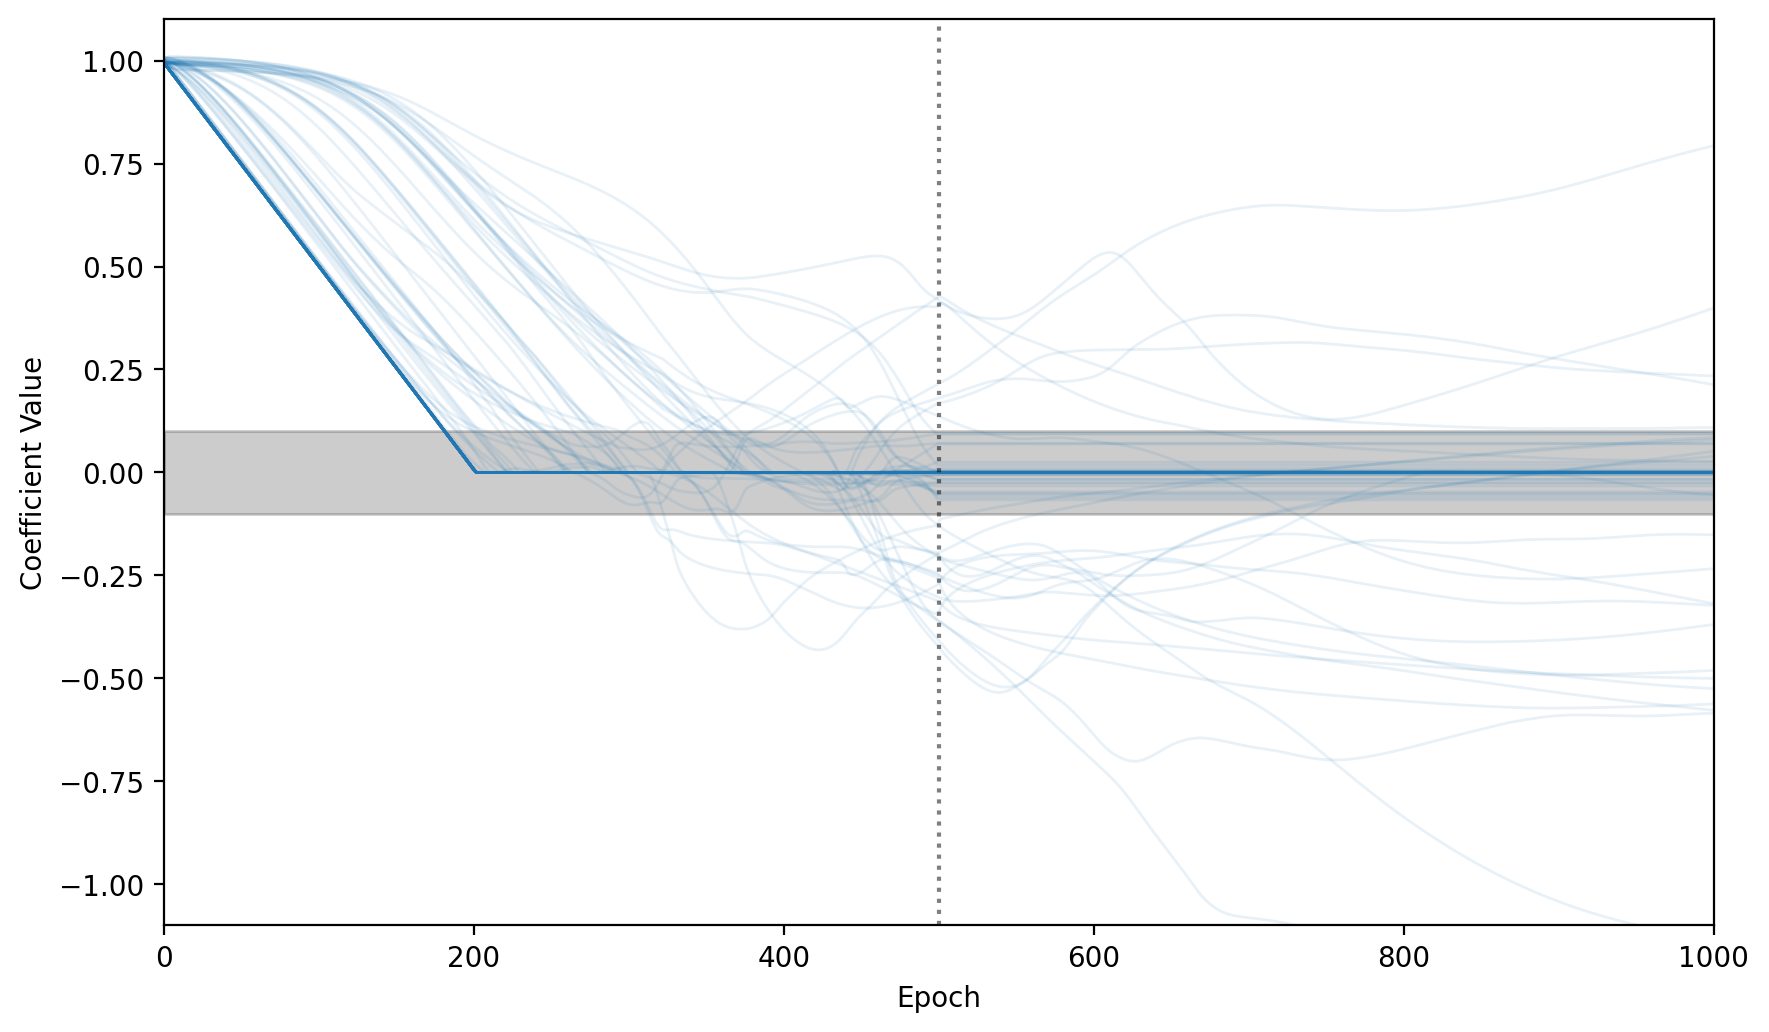

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=200)
for coefficient_history in model_coefficient_history.values():
    for i in range(12):
        ax.plot(np.arange(coefficient_history.shape[0]), coefficient_history[:, i, 0], color='tab:blue', alpha=0.1, linewidth=1)
ax.set_xlim(0, 1000); ax.set_ylim(-1.1, 1.1); ax.set_xlabel('Epoch'); ax.set_ylabel('Coefficient Value');
ax.axhspan(-0.1, 0.1, color='black', alpha=0.2); 
for threshold_epoch in np.arange(500, 1000, 500): ax.axvline(threshold_epoch, color='black', alpha=0.5, linestyle=':')

# Thresholding

In [11]:
def trend(a, lengthscale=5):
    mean_diff_last_values, var_last_values = np.mean(a[-2*lengthscale:-lengthscale], axis=0), np.var(a[-2*lengthscale:-lengthscale], axis=0)
    mean_diff_now_values, var_now_values = np.mean(a[-lengthscale:], axis=0), np.var(a[-lengthscale:], axis=0)
    return mean_diff_now_values - mean_diff_last_values, np.sqrt(var_last_values + var_now_values)

In [12]:
def trend_speed(a, lengthscale=5):
    if a.shape[0] > 2*lengthscale:
        return trend(a, lengthscale)[0]
    return np.zeros(a.shape[1:])

In [13]:
def trend_significance(a, lengthscale=5):
    if a.shape[0] > 2*lengthscale:
        t = trend(a, lengthscale)
        r = np.copy(t[0])
        r[(t[0] != 0) & (t[1] == 0)] = np.nan
        r[(t[0] != 0) & (t[1] != 0)] = t[0][(t[0] != 0) & (t[1] != 0)] / t[1][(t[0] != 0) & (t[1] != 0)]
        return r
    return np.zeros(a.shape[1:])

In [14]:
model_trend_significances = {}
model_trend_speed = {}
for name in model_names:
    model_trend_significances[name] = np.stack([trend_significance(model_coefficient_history[name][:i]) for i in range(6000)])
    model_trend_speed[name] = np.stack([trend_speed(model_coefficient_history[name][:i]) for i in range(6000)])

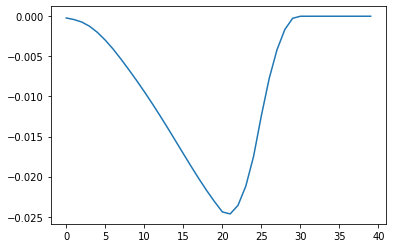

In [15]:
plt.plot(model_trend_speed[model_names[9]][480:520, 0, 0])

In [16]:
threshold_trial_epochs = np.arange(0, 5001, 500)

In [17]:
model_coefficient_activity_history = {name: (model_coefficient_history[name][threshold_trial_epochs + 20] - model_coefficient_history[name][threshold_trial_epochs + 19]).astype(bool) for name in model_names}
model_thresholded_trials = {name: np.where((~model_coefficient_activity_history[name][1:] & model_coefficient_activity_history[name][:-1])) for name in model_names}
model_thresholded_epochs = {name: ((model_thresholded_trials[name][0] + 1) * 500, model_thresholded_trials[name][1], model_thresholded_trials[name][2]) for name in model_names}
model_before_thresholded_epochs = {name: ((model_thresholded_trials[name][0] + 1) * 500 - 2, model_thresholded_trials[name][1], model_thresholded_trials[name][2]) for name in model_names}

model_before_thresholded_epochs[model_names[2]]

(array([ 498,  498,  498,  498,  498,  498,  498,  498,  998, 1498]),
 array([ 2,  3,  4,  5,  6,  7,  9, 11,  8,  0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [18]:
model_thresholded_trend_speed_values = {name: model_trend_speed[name][model_before_thresholded_epochs[name]] for name in model_names}
model_thresholded_trend_significance_values = {name: model_trend_significances[name][model_thresholded_epochs[name]] for name in model_names}
model_thresholded_coefficient_values = {name: model_coefficient_history[name][model_thresholded_epochs[name]] for name in model_names}

In [19]:
all_models_thresholded_coefficient_values = []
all_models_thresholded_trend_significance_values = []
all_models_thresholded_trend_speed_values = []

for name in model_names:
    all_models_thresholded_coefficient_values.extend(model_thresholded_coefficient_values[name])
    all_models_thresholded_trend_significance_values.extend(model_thresholded_trend_significance_values[name])
    all_models_thresholded_trend_speed_values.extend(model_thresholded_trend_speed_values[name])

In [20]:
sin_models_thresholded_coefficient_values, any_models_thresholded_coefficient_values, none_models_thresholded_coefficient_values = [], [], []
sin_models_thresholded_trend_significance_values, any_models_thresholded_trend_significance_values, none_models_thresholded_trend_significance_values = [], [], []
sin_models_thresholded_trend_speed_values, any_models_thresholded_trend_speed_values, none_models_thresholded_trend_speed_values = [], [], []

for name in model_names:
    if model_sin_detected[name]:
        sin_models_thresholded_coefficient_values.extend(model_thresholded_coefficient_values[name])
        sin_models_thresholded_trend_significance_values.extend(model_thresholded_trend_significance_values[name])
        sin_models_thresholded_trend_speed_values.extend(model_thresholded_trend_speed_values[name])
    elif model_any_detected[name]:
        any_models_thresholded_coefficient_values.extend(model_thresholded_coefficient_values[name])
        any_models_thresholded_trend_significance_values.extend(model_thresholded_trend_significance_values[name])
        any_models_thresholded_trend_speed_values.extend(model_thresholded_trend_speed_values[name])
    elif model_none_detected[name]:
        none_models_thresholded_coefficient_values.extend(model_thresholded_coefficient_values[name])
        none_models_thresholded_trend_significance_values.extend(model_thresholded_trend_significance_values[name])
        none_models_thresholded_trend_speed_values.extend(model_thresholded_trend_speed_values[name])

In [21]:
reasonable_cutoff = 0.2/5 # coefficient may change by double the ST-Zone in 5000 epochs
unreasonable_cutoff = 0.2/0.1 # coefficient may change by double the ST-Zone in 100 epochs

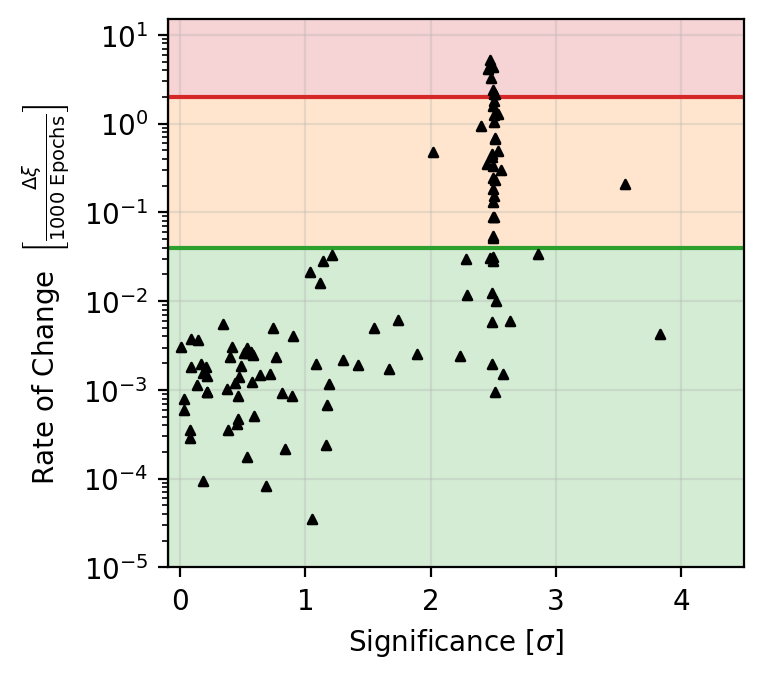

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(6.5/1.8, 6/1.8), dpi=200)
fig.tight_layout(w_pad=5)

# dm in 5 Epochs 
# 200 * dm in 1000 Epochs
ax.scatter(np.abs(all_models_thresholded_trend_significance_values), np.abs(all_models_thresholded_trend_speed_values) * 200, color='black', marker='^', s=10, zorder=3);
# ax.scatter(np.abs(sin_models_thresholded_trend_significance_values), np.abs(sin_models_thresholded_trend_speed_values) * 100, color='tab:blue', marker='^', s=10, zorder=3);
# ax.scatter(np.abs(any_models_thresholded_trend_significance_values), np.abs(any_models_thresholded_trend_speed_values) * 100, color='tab:orange', marker='s', s=10, zorder=3);
# ax.scatter(np.abs(none_models_thresholded_trend_significance_values), np.abs(none_models_thresholded_trend_speed_values) * 100, color='tab:red', marker='x', s=10, zorder=3);
ax.set_ylabel(r'Rate of Change  $\left[\frac{\Delta \xi}{1000 \,\,\mathrm{Epochs}}\right]$'); ax.set_xlabel(r'Significance $[\sigma]$'); ax.set_yscale('log'); ax.grid(alpha=0.3, zorder=1);
ax.axhspan(1e-6, reasonable_cutoff, color='tab:green', label='Coefficient Converged', alpha=0.2);
ax.axhspan(reasonable_cutoff, unreasonable_cutoff, color='tab:orange', label='Convergence Debatable', alpha=0.2);
ax.axhspan(unreasonable_cutoff, 100, color='tab:red', label='Coefficient Not Converged', alpha=0.2);
ax.axhline(unreasonable_cutoff, color='tab:red', label=r'$|\Delta \xi|$ = 0.2 in 100 Epochs')
ax.axhline(reasonable_cutoff, color='tab:green', label=r'$|\Delta \xi|$ = 0.2 in 5000 Epochs')
ax.set_ylim(1e-5, 15), ax.set_xlim(-0.1, 4.5); 
# ax.legend(); 